# Customer Churn Prediction + Model Monitor
This notebook shows how to:
* Host a machine learning model in Amazon SageMaker and capture inference requests, results, and metadata 
* Analyze a training dataset to generate baseline constraints
* Monitor a live endpoint for violations against constraints

---
## Background

Amazon SageMaker provides every developer and data scientist with the ability to build, train, and deploy machine learning models quickly. Amazon SageMaker is a fully-managed service that encompasses the entire machine learning workflow. You can label and prepare your data, choose an algorithm, train a model, and then tune and optimize it for deployment. You can deploy your models to production with Amazon SageMaker to make predictions and lower costs than was previously possible.

In addition, Amazon SageMaker enables you to capture the input, output and metadata for invocations of the models that you deploy. It also enables you to analyze the data and monitor its quality. In this notebook, you learn how Amazon SageMaker enables these capabilities.

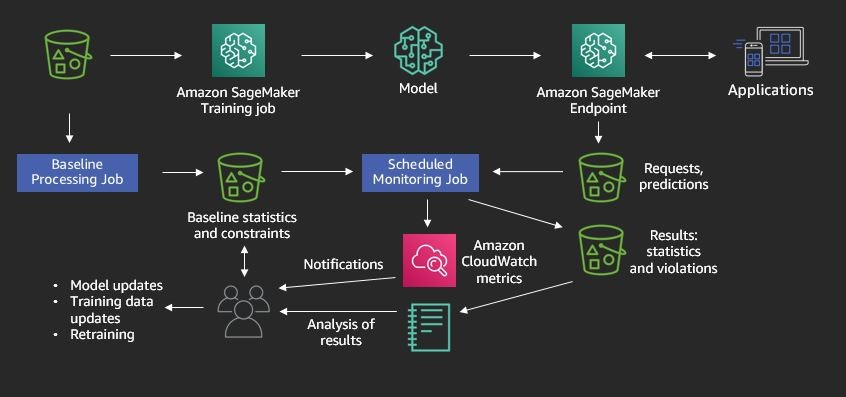


## Setup

To get started, make sure you have these prerequisites completed.

* Specify an AWS Region to host your model.
* An IAM role ARN exists that is used to give Amazon SageMaker access to your data in Amazon Simple Storage Service (Amazon S3). See the documentation for how to fine tune the permissions needed. 
* Create an S3 bucket used to store the data used to train your model, any additional model data, and the data captured from model invocations. For demonstration purposes, you are using the same bucket for these. In reality, you might want to separate them with different security policies.

### Imports

In [2]:
from sagemaker import get_execution_role, session
from sagemaker.model import Model
import sagemaker
import boto3
import json
import re
import os

### S3 Bucket + Session + Role

In [3]:
session = sagemaker.Session()

bucket = session.default_bucket()
prefix = 'xgboost-churn/model-monitor'
# Copy the training job name of the previous training job you ran from the SageMaker Console 
# under Training Jobs
training_job_name = 'sagemaker-xgboost-2020-08-26-02-12-12-947' # CHANGE THIS
model_url = 's3://{}/xgboost-churn/output/{}/output/model.tar.gz'.format(bucket, training_job_name)
container_image_uri = '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3'
role = get_execution_role()

### S3 Paths

In [4]:
data_capture_prefix = '{}/datacapture'.format(prefix)
s3_capture_upload_path = 's3://{}/{}'.format(bucket, data_capture_prefix)

reports_prefix = '{}/reports'.format(prefix)
s3_report_path = 's3://{}/{}'.format(bucket,reports_prefix)

code_prefix = '{}/code'.format(prefix)
s3_code_preprocessor_uri = 's3://{}/{}/{}'.format(bucket, code_prefix, 'preprocessor.py')
s3_code_postprocessor_uri = 's3://{}/{}/{}'.format(bucket, code_prefix, 'postprocessor.py')

print("Capture path: {}".format(s3_capture_upload_path))
print("Report path: {}".format(s3_report_path))
print("Preproc Code path: {}".format(s3_code_preprocessor_uri))
print("Postproc Code path: {}".format(s3_code_postprocessor_uri))

Capture path: s3://sagemaker-us-east-1-892313895307/xgboost-churn/model-monitor/datacapture
Report path: s3://sagemaker-us-east-1-892313895307/xgboost-churn/model-monitor/reports
Preproc Code path: s3://sagemaker-us-east-1-892313895307/xgboost-churn/model-monitor/code/preprocessor.py
Postproc Code path: s3://sagemaker-us-east-1-892313895307/xgboost-churn/model-monitor/code/postprocessor.py


## Capture Real-Time Inference Data from SageMaker endpoints

### Load previously trained Customer Churn model

In [5]:
model = Model(image=container_image_uri, model_data=model_url, role=role)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [6]:
model.__dict__

{'model_data': 's3://sagemaker-us-east-1-892313895307/xgboost-churn/output/sagemaker-xgboost-2020-08-26-02-12-12-947/output/model.tar.gz',
 'image': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3',
 'role': 'arn:aws:iam::892313895307:role/service-role/AmazonSageMaker-ExecutionRole-20200609T132696',
 'predictor_cls': None,
 'env': {},
 'name': None,
 'vpc_config': None,
 'sagemaker_session': None,
 '_model_name': None,
 'endpoint_name': None,
 '_is_compiled_model': False,
 '_enable_network_isolation': False,
 'model_kms_key': None}

### Re-deploy using DataCaptureConfig

To enable data capture for monitoring the model data quality, you specify the new capture option called DataCaptureConfig. You can capture the request payload, the response payload or both with this configuration. The capture config applies to all variants. Go ahead with the deployment.

In [7]:
from sagemaker.model_monitor import DataCaptureConfig
from time import gmtime, strftime

In [8]:
endpoint_name = 'xgb-churn-pred-model-monitor-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("EndpointName={}".format(endpoint_name))

data_capture_config = DataCaptureConfig(
                        enable_capture=True,
                        sampling_percentage=100,
                        destination_s3_uri=s3_capture_upload_path)

predictor = model.deploy(initial_instance_count=1,
                instance_type='ml.m5.xlarge',
                endpoint_name=endpoint_name,
                data_capture_config=data_capture_config)

EndpointName=xgb-churn-pred-model-monitor-2020-08-26-02-34-35
-------------!

### Invoke the Deployed Model Monitor Endpoint 


You can now send data to this endpoint to get inferences in real time. Because you enabled the data capture in the previous steps, the request and response payload, along with some additional metadata, is saved in the Amazon Simple Storage Service (Amazon S3) location you have specified in the DataCaptureConfig.

This step invokes the endpoint with included sample data for about 2 minutes. Data is captured based on the sampling percentage specified and the capture continues until the data capture option is turned off.

In [9]:
from sagemaker.predictor import RealTimePredictor
import time

In [10]:
predictor = RealTimePredictor(endpoint=endpoint_name, content_type='text/csv')

In [11]:
predictor.__dict__

{'endpoint': 'xgb-churn-pred-model-monitor-2020-08-26-02-34-35',
 'sagemaker_session': <sagemaker.session.Session at 0x7f1df2090240>,
 'serializer': None,
 'deserializer': None,
 'content_type': 'text/csv',
 'accept': None,
 '_endpoint_config_name': 'xgb-churn-pred-model-monitor-2020-08-26-02-34-35',
 '_model_names': <map at 0x7f1df1689ac8>}

In [18]:
i = 0
with open('./DATA/test.csv', 'r') as f:
    for row in f:
        i += 1
        payload = row.rstrip('\n')[2:]
        response = predictor.predict(data=payload)
        if i == 100:
            print("Done!") 
            break

Done!


### View captured data

Now list the data capture files stored in Amazon S3. You should expect to see different files from different time periods organized based on the hour in which the invocation occurred. The format of the Amazon S3 path is:

`s3://{destination-bucket-prefix}/{endpoint-name}/{variant-name}/yyyy/mm/dd/hh/filename.jsonl`

In [20]:
s3_client = boto3.Session().client('s3')
current_endpoint_capture_prefix = '{}/{}'.format(data_capture_prefix, endpoint_name)
result = s3_client.list_objects(Bucket=bucket, Prefix=current_endpoint_capture_prefix)
capture_files = [capture_file.get("Key") for capture_file in result.get('Contents')]
print("Found Capture Files:")
print("\n ".join(capture_files))

Found Capture Files:
xgboost-churn/model-monitor/datacapture/xgb-churn-pred-model-monitor-2020-08-26-02-34-35/AllTraffic/2020/08/26/03/13-35-812-ac498236-e57e-4bea-ab92-c5bbfd77d29b.jsonl
 xgboost-churn/model-monitor/datacapture/xgb-churn-pred-model-monitor-2020-08-26-02-34-35/AllTraffic/2020/08/26/03/14-35-921-d219b7d2-0f45-4b57-883b-49281f2f44d7.jsonl
 xgboost-churn/model-monitor/datacapture/xgb-churn-pred-model-monitor-2020-08-26-02-34-35/AllTraffic/2020/08/26/03/15-36-418-4d232a38-7930-44d4-b484-d48b820e1f1f.jsonl


Next, view the contents of a single capture file. Here you should see all the data captured in an Amazon SageMaker specific JSON-line formatted file. Take a quick peek at the first few lines in the captured file.

In [21]:
def get_obj_body(obj_key):
    return s3_client.get_object(Bucket=bucket, Key=obj_key).get('Body').read().decode("utf-8")

capture_file = get_obj_body(capture_files[-1])
print(capture_file[:2000])

{"captureData":{"endpointInput":{"observedContentType":"text/csv","mode":"INPUT","data":"174,33,167.8,91,205.3,91,130.0,132,14.5,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1","encoding":"CSV"},"endpointOutput":{"observedContentType":"text/csv; charset=utf-8","mode":"OUTPUT","data":"0.6627473831176758","encoding":"CSV"}},"eventMetadata":{"eventId":"f622487d-9332-423e-a74f-e37c49b4cfe1","inferenceTime":"2020-08-26T03:15:36Z"},"eventVersion":"0"}
{"captureData":{"endpointInput":{"observedContentType":"text/csv","mode":"INPUT","data":"147,35,157.5,109,189.6,67,227.0,76,11.1,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1","encoding":"CSV"},"endpointOutput":{"observedContentType":"text/csv; charset=utf-8","mode":"OUTPUT","data":"0.6961984634399414","encoding":"CSV"}},"eventMetadata":{"eventId":"fb8c2e02-64c8-437d-b785-03ceb5c2180d","inferenceTime

Finally, the contents of a single line is present below in a formatted JSON file so that you can observe a little better.

In [22]:
import json


print(json.dumps(json.loads(capture_file.split('\n')[0]), indent=2))

{
  "captureData": {
    "endpointInput": {
      "observedContentType": "text/csv",
      "mode": "INPUT",
      "data": "174,33,167.8,91,205.3,91,130.0,132,14.5,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1",
      "encoding": "CSV"
    },
    "endpointOutput": {
      "observedContentType": "text/csv; charset=utf-8",
      "mode": "OUTPUT",
      "data": "0.6627473831176758",
      "encoding": "CSV"
    }
  },
  "eventMetadata": {
    "eventId": "f622487d-9332-423e-a74f-e37c49b4cfe1",
    "inferenceTime": "2020-08-26T03:15:36Z"
  },
  "eventVersion": "0"
}


As you can see, each inference request is captured in one line in the jsonl file. The line contains both the input and output merged together. In the example, you provided the ContentType as `text/csv` which is reflected in the `observedContentType` value. Also, you expose the encoding that you used to encode the input and output payloads in the capture format with the `encoding` value.

To recap, you observed how you can enable capturing the input or output payloads to an endpoint with a new parameter. You have also observed what the captured format looks like in Amazon S3. Next, continue to explore how Amazon SageMaker helps with monitoring the data collected in Amazon S3.

## Baseling & Continuous Monitoring

In addition to collecting the data, Amazon SageMaker provides the capability for you to monitor and evaluate the data observed by the endpoints. For this:
1. Create a baseline with which you compare the realtime traffic. 
1. Once a baseline is ready, setup a schedule to continously evaluate and compare against the baseline.

The training dataset with which you trained the model is usually a good baseline dataset. Note that the training dataset data schema and the inference dataset schema should exactly match (i.e. the number and order of the features).

From the training dataset you can ask Amazon SageMaker to suggest a set of baseline `constraints` and generate descriptive `statistics` to explore the data. For this example, upload the training dataset that was used to train the pre-trained model included in this example. If you already have it in Amazon S3, you can directly point to it.

### Setup Baseline URIs

In [23]:
# copy over the training dataset to Amazon S3 (if you already have it in Amazon S3, you could reuse it)
baseline_prefix = prefix + '/baselining'
baseline_data_prefix = baseline_prefix + '/data'
baseline_results_prefix = baseline_prefix + '/results'

baseline_data_uri = 's3://{}/{}'.format(bucket,baseline_data_prefix)
baseline_results_uri = 's3://{}/{}'.format(bucket, baseline_results_prefix)
print('Baseline data uri: {}'.format(baseline_data_uri))
print('Baseline results uri: {}'.format(baseline_results_uri))

Baseline data uri: s3://sagemaker-us-east-1-892313895307/xgboost-churn/model-monitor/baselining/data
Baseline results uri: s3://sagemaker-us-east-1-892313895307/xgboost-churn/model-monitor/baselining/results


### Upload Train Set to S3 (with Header)

In [34]:
training_data_file = open('./DATA/train-with-header.csv', 'rb')
s3_key = os.path.join(baseline_prefix, 'data', 'training-dataset-with-header.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(s3_key).upload_fileobj(training_data_file)

### Create a baselining job with training dataset

Now that you have the training data ready in Amazon S3, start a job to `suggest` constraints. `DefaultModelMonitor.suggest_baseline(..)` starts a `ProcessingJob` using an Amazon SageMaker provided Model Monitor container to generate the constraints.

In [35]:
from sagemaker.model_monitor.dataset_format import DatasetFormat
from sagemaker.model_monitor import DefaultModelMonitor

In [36]:
default_model_monitor = DefaultModelMonitor(
                            role=role,
                            instance_count=1,
                            instance_type='ml.r5.xlarge',
                            volume_size_in_gb=20,
                            max_runtime_in_seconds=3600,
                        )

In [37]:
default_model_monitor.__dict__

{'role': 'arn:aws:iam::892313895307:role/service-role/AmazonSageMaker-ExecutionRole-20200609T132696',
 'image_uri': '156813124566.dkr.ecr.us-east-1.amazonaws.com/sagemaker-model-monitor-analyzer',
 'instance_count': 1,
 'instance_type': 'ml.r5.xlarge',
 'entrypoint': None,
 'volume_size_in_gb': 20,
 'volume_kms_key': None,
 'output_kms_key': None,
 'max_runtime_in_seconds': 3600,
 'base_job_name': None,
 'sagemaker_session': <sagemaker.session.Session at 0x7f1df1582128>,
 'env': None,
 'tags': None,
 'network_config': None,
 'baselining_jobs': [],
 'latest_baselining_job': None,
 'arguments': None,
 'latest_baselining_job_name': None,
 'monitoring_schedule_name': None}

In [38]:
default_model_monitor.suggest_baseline(
                            baseline_dataset=baseline_data_uri + '/training-dataset-with-header.csv',
                            dataset_format=DatasetFormat.csv(header=True),
                            output_s3_uri=baseline_results_uri,
                            wait=True
                        )


Job Name:  baseline-suggestion-job-2020-08-26-04-06-06-085
Inputs:  [{'InputName': 'baseline_dataset_input', 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-892313895307/xgboost-churn/model-monitor/baselining/data/training-dataset-with-header.csv', 'LocalPath': '/opt/ml/processing/input/baseline_dataset_input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'monitoring_output', 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-892313895307/xgboost-churn/model-monitor/baselining/results', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
........................2020-08-26 04:09:51,020 - __main__ - INFO - All params:{'ProcessingJobArn': 'arn:aws:sagemaker:us-east-1:892313895307:processing-job/baseline-suggestion-job-2020-08-26-04-06-06-085', 'ProcessingJobName': 'baseline-suggestion-job-2020-08-26-04-06-06-085', 'Environment': {'dataset_format': '{"csv": {"header": 

2020-08-26 04:10:12,720 - DefaultDataAnalyzer - INFO - Running command: bin/spark-submit --master yarn --deploy-mode client --conf spark.hadoop.fs.s3a.aws.credentials.provider=org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider --conf spark.serializer=org.apache.spark.serializer.KryoSerializer /opt/amazon/sagemaker-data-analyzer-1.0-jar-with-dependencies.jar --analytics_input /tmp/spark_job_config.json
2020-08-26 04:10:13 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2020-08-26 04:10:13 INFO  Main:26 - Start analyzing with args: --analytics_input /tmp/spark_job_config.json
2020-08-26 04:10:13 INFO  Main:29 - Analytics input path: DataAnalyzerParams(/tmp/spark_job_config.json,yarn)
2020-08-26 04:10:13 INFO  FileUtil:66 - Read file from path /tmp/spark_job_config.json.
2020-08-26 04:10:14 INFO  SparkContext:54 - Running Spark version 2.3.1
2020-08-26 04:10:14 INFO  SparkContext:54 - Submitted applicatio

2020-08-26 04:10:44 INFO  YarnClientSchedulerBackend:54 - SchedulerBackend is ready for scheduling beginning after waiting maxRegisteredResourcesWaitingTime: 30000(ms)
2020-08-26 04:10:44 WARN  SparkContext:66 - Spark is not running in local mode, therefore the checkpoint directory must not be on the local filesystem. Directory '/tmp' appears to be on the local filesystem.
2020-08-26 04:10:45 INFO  SharedState:54 - Setting hive.metastore.warehouse.dir ('null') to the value of spark.sql.warehouse.dir ('file:/usr/spark-2.3.1/spark-warehouse').
2020-08-26 04:10:45 INFO  SharedState:54 - Warehouse path is 'file:/usr/spark-2.3.1/spark-warehouse'.
2020-08-26 04:10:45 INFO  StateStoreCoordinatorRef:54 - Registered StateStoreCoordinator endpoint
2020-08-26 04:10:45 INFO  DatasetReader:90 - Files to process:List(file:///opt/ml/processing/input/baseline_dataset_input/training-dataset-with-header.csv)
2020-08-26 04:10:46 INFO  FileSourceStrategy:54 - Pruning directories with: 
2020-08-26 04:10:46

2020-08-26 04:10:55 INFO  TaskSetManager:54 - Finished task 0.0 in stage 2.0 (TID 2) in 3907 ms on algo-1 (executor 1) (1/1)
2020-08-26 04:10:55 INFO  YarnScheduler:54 - Removed TaskSet 2.0, whose tasks have all completed, from pool 
2020-08-26 04:10:55 INFO  DAGScheduler:54 - ShuffleMapStage 2 (collect at AnalysisRunner.scala:313) finished in 3.943 s
2020-08-26 04:10:55 INFO  DAGScheduler:54 - looking for newly runnable stages
2020-08-26 04:10:55 INFO  DAGScheduler:54 - running: Set()
2020-08-26 04:10:55 INFO  DAGScheduler:54 - waiting: Set(ResultStage 3)
2020-08-26 04:10:55 INFO  DAGScheduler:54 - failed: Set()
2020-08-26 04:10:55 INFO  DAGScheduler:54 - Submitting ResultStage 3 (MapPartitionsRDD[27] at collect at AnalysisRunner.scala:313), which has no missing parents
2020-08-26 04:10:55 INFO  MemoryStore:54 - Block broadcast_6 stored as values in memory (estimated size 800.8 KB, free 1456.5 MB)
2020-08-26 04:10:55 INFO  MemoryStore:54 - Block broadcast_6_piece0 stored as bytes in m

2020-08-26 04:11:02 INFO  TaskSetManager:54 - Finished task 0.0 in stage 5.0 (TID 5) in 1796 ms on algo-1 (executor 1) (1/1)
2020-08-26 04:11:02 INFO  YarnScheduler:54 - Removed TaskSet 5.0, whose tasks have all completed, from pool 
2020-08-26 04:11:02 INFO  DAGScheduler:54 - ShuffleMapStage 5 (collect at AnalysisRunner.scala:313) finished in 1.812 s
2020-08-26 04:11:02 INFO  DAGScheduler:54 - looking for newly runnable stages
2020-08-26 04:11:02 INFO  DAGScheduler:54 - running: Set()
2020-08-26 04:11:02 INFO  DAGScheduler:54 - waiting: Set(ResultStage 6)
2020-08-26 04:11:02 INFO  DAGScheduler:54 - failed: Set()
2020-08-26 04:11:02 INFO  DAGScheduler:54 - Submitting ResultStage 6 (MapPartitionsRDD[45] at collect at AnalysisRunner.scala:313), which has no missing parents
2020-08-26 04:11:02 INFO  MemoryStore:54 - Block broadcast_9 stored as values in memory (estimated size 335.4 KB, free 1457.5 MB)
2020-08-26 04:11:02 INFO  MemoryStore:54 - Block broadcast_9_piece0 stored as bytes in m

### Explore the generated constraints and statistics

In [39]:
s3_client = boto3.Session().client('s3')
result = s3_client.list_objects(Bucket=bucket, Prefix=baseline_results_prefix)
report_files = [report_file.get('Key') for report_file in result.get('Contents')]
print('Found Files:')
print("\n ".join(report_files))

Found Files:
xgboost-churn/model-monitor/baselining/results/constraints.json
 xgboost-churn/model-monitor/baselining/results/statistics.json


In [40]:
import pandas as pd

baseline_job = default_model_monitor.latest_baselining_job
schema_df = pd.io.json.json_normalize(baseline_job.baseline_statistics().body_dict['features'])
schema_df.head(10)

Parameter 'session' will be renamed to 'sagemaker_session' in SageMaker Python SDK v2.


,name,inferred_type,numerical_statistics.common.num_present,numerical_statistics.common.num_missing,numerical_statistics.mean,numerical_statistics.sum,numerical_statistics.std_dev,numerical_statistics.min,numerical_statistics.max,numerical_statistics.distribution.kll.buckets,numerical_statistics.distribution.kll.sketch.parameters.c,numerical_statistics.distribution.kll.sketch.parameters.k,numerical_statistics.distribution.kll.sketch.data
0,Churn,Integral,2333,0,0.139306,325.0,0.346265,0.0,1.0,"[{'lower_bound': 0.0, 'upper_bound': 0.1, 'cou...",0.64,2048.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
1,Account Length,Integral,2333,0,101.276897,236279.0,39.552442,1.0,243.0,"[{'lower_bound': 1.0, 'upper_bound': 25.2, 'co...",0.64,2048.0,"[[119.0, 100.0, 111.0, 181.0, 95.0, 104.0, 70...."
2,VMail Message,Integral,2333,0,8.214316,19164.0,13.776908,0.0,51.0,"[{'lower_bound': 0.0, 'upper_bound': 5.1, 'cou...",0.64,2048.0,"[[19.0, 0.0, 0.0, 40.0, 36.0, 0.0, 0.0, 24.0, ..."
3,Day Mins,Fractional,2333,0,180.226489,420468.4,53.987179,0.0,350.8,"[{'lower_bound': 0.0, 'upper_bound': 35.08, 'c...",0.64,2048.0,"[[178.1, 160.3, 197.1, 105.2, 283.1, 113.6, 23..."
4,Day Calls,Integral,2333,0,100.259323,233905.0,20.165008,0.0,165.0,"[{'lower_bound': 0.0, 'upper_bound': 16.5, 'co...",0.64,2048.0,"[[110.0, 138.0, 117.0, 61.0, 112.0, 87.0, 122...."
5,Eve Mins,Fractional,2333,0,200.050107,466716.9,50.015928,31.2,361.8,"[{'lower_bound': 31.2, 'upper_bound': 64.26, '...",0.64,2048.0,"[[212.8, 221.3, 227.8, 341.3, 286.2, 158.6, 29..."
6,Eve Calls,Integral,2333,0,99.573939,232306.0,19.675578,12.0,170.0,"[{'lower_bound': 12.0, 'upper_bound': 27.8, 'c...",0.64,2048.0,"[[100.0, 92.0, 128.0, 79.0, 86.0, 98.0, 112.0,..."
7,Night Mins,Fractional,2333,0,201.388598,469839.6,50.627961,23.2,395.0,"[{'lower_bound': 23.2, 'upper_bound': 60.37999...",0.64,2048.0,"[[226.3, 150.4, 214.0, 165.7, 261.7, 187.7, 20..."
8,Night Calls,Integral,2333,0,100.227175,233830.0,19.282029,42.0,175.0,"[{'lower_bound': 42.0, 'upper_bound': 55.3, 'c...",0.64,2048.0,"[[123.0, 120.0, 101.0, 97.0, 129.0, 87.0, 112...."
9,Intl Mins,Fractional,2333,0,10.253065,23920.4,2.778766,0.0,18.4,"[{'lower_bound': 0.0, 'upper_bound': 1.8399999...",0.64,2048.0,"[[10.0, 11.2, 9.3, 6.3, 11.3, 10.5, 0.0, 9.7, ..."


In [41]:
constraints_df = pd.io.json.json_normalize(baseline_job.suggested_constraints().body_dict['features'])
constraints_df.head(10)

Parameter 'session' will be renamed to 'sagemaker_session' in SageMaker Python SDK v2.


,name,inferred_type,completeness,num_constraints.is_non_negative
0,Churn,Integral,1.0,True
1,Account Length,Integral,1.0,True
2,VMail Message,Integral,1.0,True
3,Day Mins,Fractional,1.0,True
4,Day Calls,Integral,1.0,True
5,Eve Mins,Fractional,1.0,True
6,Eve Calls,Integral,1.0,True
7,Night Mins,Fractional,1.0,True
8,Night Calls,Integral,1.0,True
9,Intl Mins,Fractional,1.0,True


## Monitoring Schedules

<p><b>Analyzing collected data for data quality issues</b></p>

When you have collected the data above, analyze and monitor the data with Monitoring Schedules

### Create a Schedule

In [42]:
# First, copy over some test scripts to the S3 bucket so that they can be used for pre and post processing
boto3.Session().resource('s3').Bucket(bucket).Object(code_prefix + '/preprocessor.py').upload_file('preprocessor.py')
boto3.Session().resource('s3').Bucket(bucket).Object(code_prefix + '/postprocessor.py').upload_file('postprocessor.py')

You can create a model monitoring schedule for the endpoint created earlier. Use the baseline resources (constraints and statistics) to compare against the realtime traffic.

In [43]:
from sagemaker.model_monitor import CronExpressionGenerator
from time import gmtime, strftime

mon_schedule_name = 'xgb-churn-pred-model-monitor-schedule-' + strftime('%Y-%m-%d-%H-%M-%S', gmtime())

default_model_monitor.create_monitoring_schedule(
    monitor_schedule_name=mon_schedule_name,
    endpoint_input=predictor.endpoint,
    post_analytics_processor_script=s3_code_postprocessor_uri,
    output_s3_uri=s3_report_path,
    statistics=default_model_monitor.baseline_statistics(),
    constraints=default_model_monitor.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,
)

Parameter 'session' will be renamed to 'sagemaker_session' in SageMaker Python SDK v2.
Parameter 'session' will be renamed to 'sagemaker_session' in SageMaker Python SDK v2.



Creating Monitoring Schedule with name: xgb-churn-pred-model-monitor-schedule-2020-08-26-04-14-09


### Start generating some artificial traffic
The cell below starts a thread to send some traffic to the endpoint. Note that you need to stop the kernel to terminate this thread. If there is no traffic, the monitoring jobs are marked as `Failed` since there is no data to process.

In [44]:
from threading import Thread
from time import sleep
import time


endpoint_name=predictor.endpoint
runtime_client = boto3.client('runtime.sagemaker')

# (just repeating code from above for convenience / able to run this section independently)
def invoke_endpoint(ep_name, file_name, runtime_client):
    with open(file_name, 'r') as f:
        for row in f:
            payload = row.rstrip('\n')
            response = runtime_client.invoke_endpoint(EndpointName=ep_name,
                                          ContentType='text/csv', 
                                          Body=payload)
            response['Body'].read()
            time.sleep(1)
            
def invoke_endpoint_forever():
    while True:
        invoke_endpoint(endpoint_name, './DATA/test-dataset-input-cols.csv', runtime_client)
        
thread = Thread(target = invoke_endpoint_forever)
thread.start()

# Note that you need to stop the kernel to stop the invocations

### Describe and inspect the schedule
Once you describe, observe that the MonitoringScheduleStatus changes to Scheduled.

In [45]:
desc_schedule_result = default_model_monitor.describe_schedule()
print('Schedule status: {}'.format(desc_schedule_result['MonitoringScheduleStatus']))

Schedule status: Scheduled


### List executions
The schedule starts jobs at the previously specified intervals. Here, you list the latest five executions. Note that if you are kicking this off after creating the hourly schedule, you might find the executions empty. You might have to wait until you cross the hour boundary (in UTC) to see executions kick off. The code below has the logic for waiting.

Note: Even for an hourly schedule, Amazon SageMaker has a buffer period of 20 minutes to schedule your execution. You might see your execution start in anywhere from zero to ~20 minutes from the hour boundary. This is expected and done for load balancing in the backend.

In [48]:
mon_executions = default_model_monitor.list_executions()
print("We created a hourly schedule above and it will kick off executions ON the hour (plus 0 - 20 min buffer.\nWe will have to wait till we hit the hour...")

while len(mon_executions) == 0:
    print("Waiting for the 1st execution to happen...")
    time.sleep(60)
    mon_executions = default_model_monitor.list_executions()    

We created a hourly schedule above and it will kick off executions ON the hour (plus 0 - 20 min buffer.
We will have to wait till we hit the hour...


### Inspect a specific execution (latest execution)
In the previous cell, you picked up the latest completed or failed scheduled execution. Here are the possible terminal states and what each of them mean: 
* Completed - This means the monitoring execution completed and no issues were found in the violations report.
* CompletedWithViolations - This means the execution completed, but constraint violations were detected.
* Failed - The monitoring execution failed, maybe due to client error (perhaps incorrect role premissions) or infrastructure issues. Further examination of FailureReason and ExitMessage is necessary to identify what exactly happened.
* Stopped - job exceeded max runtime or was manually stopped.

In [49]:
latest_execution = mon_executions[-1] # latest execution's index is -1, second to last is -2 and so on..
time.sleep(60)
latest_execution.wait(logs=False)

print("Latest execution status: {}".format(latest_execution.describe()['ProcessingJobStatus']))
print("Latest execution result: {}".format(latest_execution.describe()['ExitMessage']))

latest_job = latest_execution.describe()
if (latest_job['ProcessingJobStatus'] != 'Completed'):
        print("====STOP==== \n No completed executions to inspect further. Please wait till an execution completes or investigate previously reported failures.")

!Latest execution status: Completed
Latest execution result: CompletedWithViolations: Job completed successfully with 60 violations.


In [50]:
report_uri=latest_execution.output.destination
print('Report Uri: {}'.format(report_uri))

Report Uri: s3://sagemaker-us-east-1-892313895307/xgboost-churn/model-monitor/reports/xgb-churn-pred-model-monitor-2020-08-26-02-34-35/xgb-churn-pred-model-monitor-schedule-2020-08-26-04-14-09/2020/08/26/12


### List the generated reports

In [51]:
from urllib.parse import urlparse


s3uri = urlparse(report_uri)
report_bucket = s3uri.netloc
report_key = s3uri.path.lstrip('/')
print('Report bucket: {}'.format(report_bucket))
print('Report key: {}'.format(report_key))

s3_client = boto3.Session().client('s3')
result = s3_client.list_objects(Bucket=report_bucket, Prefix=report_key)
report_files = [report_file.get("Key") for report_file in result.get('Contents')]
print("Found Report Files:")
print("\n ".join(report_files))

Report bucket: sagemaker-us-east-1-892313895307
Report key: xgboost-churn/model-monitor/reports/xgb-churn-pred-model-monitor-2020-08-26-02-34-35/xgb-churn-pred-model-monitor-schedule-2020-08-26-04-14-09/2020/08/26/12
Found Report Files:
xgboost-churn/model-monitor/reports/xgb-churn-pred-model-monitor-2020-08-26-02-34-35/xgb-churn-pred-model-monitor-schedule-2020-08-26-04-14-09/2020/08/26/12/constraint_violations.json
 xgboost-churn/model-monitor/reports/xgb-churn-pred-model-monitor-2020-08-26-02-34-35/xgb-churn-pred-model-monitor-schedule-2020-08-26-04-14-09/2020/08/26/12/constraints.json
 xgboost-churn/model-monitor/reports/xgb-churn-pred-model-monitor-2020-08-26-02-34-35/xgb-churn-pred-model-monitor-schedule-2020-08-26-04-14-09/2020/08/26/12/statistics.json


### Violations report

If there are any violations compared to the baseline, they will be listed here.

In [52]:
violations = default_model_monitor.latest_monitoring_constraint_violations()
pd.set_option('display.max_colwidth', -1)
constraints_df = pd.io.json.json_normalize(violations.body_dict["violations"])
constraints_df.head(50)

Parameter 'session' will be renamed to 'sagemaker_session' in SageMaker Python SDK v2.


,feature_name,constraint_check_type,description
0,State_SD,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.68908988128887% of data is Integral."
1,State_DC,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.68908988128887% of data is Integral."
2,State_OR,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.68908988128887% of data is Integral."
3,State_MA,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.68908988128887% of data is Integral."
4,State_KY,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.68908988128887% of data is Integral."
5,State_NE,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.68908988128887% of data is Integral."
6,State_AR,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.68908988128887% of data is Integral."
7,State_NC,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.68908988128887% of data is Integral."
8,State_MI,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.68908988128887% of data is Integral."
9,State_TX,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.68908988128887% of data is Integral."


### Other commands
We can also start and stop the monitoring schedules.

In [ ]:
# my_default_monitor.stop_monitoring_schedule()
# my_default_monitor.start_monitoring_schedule()

## Delete the resources

You can keep your endpoint running to continue capturing data. If you do not plan to collect more data or use this endpoint further, you should delete the endpoint to avoid incurring additional charges. Note that deleting your endpoint does not delete the data that was captured during the model invocations. That data persists in Amazon S3 until you delete it yourself.

But before that, you need to delete the schedule first.

In [ ]:
my_default_monitor.delete_monitoring_schedule()
time.sleep(60) # actually wait for the deletion

In [ ]:
predictor.delete_endpoint()

In [ ]:
predictor.delete_model()